In [1]:
# manipulacja danymi
import numpy as np
import pandas as pd

# wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns

# podział danych na zbiory treningowe/walidacyjne/testowe
from sklearn.model_selection import train_test_split, GridSearchCV

# budowa Pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

# redukcja wymiarowości
from sklearn.decomposition import PCA

# model
from sklearn.linear_model import LogisticRegression

# ewaluacja
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

In [2]:
dataset = pd.read_csv('diabetes.csv')
dataset

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0
...,...,...,...,...,...,...,...,...,...,...
14995,1490300,10,65,60,46,177,33.512468,0.148327,41,1
14996,1744410,2,73,66,27,168,30.132636,0.862252,38,1
14997,1742742,0,93,89,43,57,18.690683,0.427049,24,0
14998,1099353,0,132,98,18,161,19.791645,0.302257,23,0


In [29]:
X = dataset.drop(['Diabetic'], axis=1).copy()
y = dataset['Diabetic'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [30]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []

def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################

    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
 
    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    new_row = pd.DataFrame([{'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric}])
    metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)
    return metrics_dataframe

In [31]:
num_features = ['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age']

In [32]:
# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='median'))
])

In [33]:
# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)
])

In [34]:
model_pipeline_v1 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])
model_pipeline_v1.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric_preprocessing', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


              precision    recall  f1-score   support

           0       0.82      0.88      0.85      2500
           1       0.72      0.60      0.65      1250

    accuracy                           0.79      3750
   macro avg       0.77      0.74      0.75      3750
weighted avg       0.78      0.79      0.78      3750



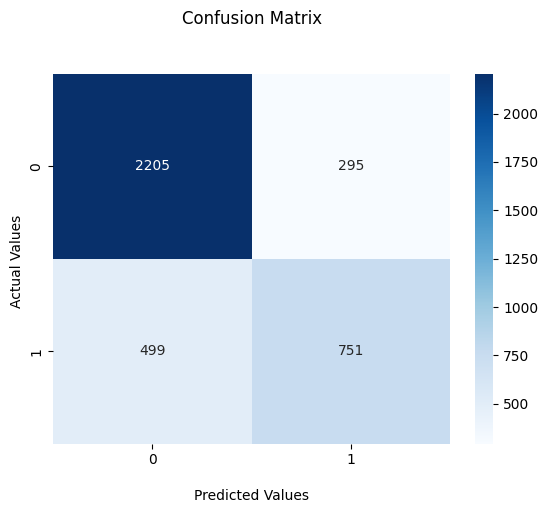

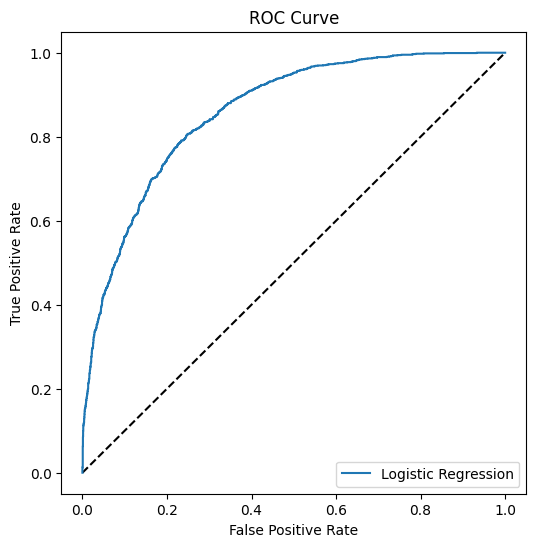

/var/folders/r9/rrn82r812j9fccz3mm0wxk5w0000gp/T/ipykernel_68442/2386929870.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)


,Model,F1_score,AUC
0,Logistic Regression,0.654181,0.859499


In [35]:
calculate_metrics(model_pipeline_v1, 'Logistic Regression', X_test, y_test)

In [36]:
list(model_pipeline_v1.get_params().keys())

['memory',
 'steps',
 'transform_input',
 'verbose',
 'preprocessor',
 'model',
 'preprocessor__force_int_remainder_cols',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__verbose_feature_names_out',
 'preprocessor__numeric_preprocessing',
 'preprocessor__numeric_preprocessing__memory',
 'preprocessor__numeric_preprocessing__steps',
 'preprocessor__numeric_preprocessing__transform_input',
 'preprocessor__numeric_preprocessing__verbose',
 'preprocessor__numeric_preprocessing__fill_missings',
 'preprocessor__numeric_preprocessing__fill_missings__add_indicator',
 'preprocessor__numeric_preprocessing__fill_missings__copy',
 'preprocessor__numeric_preprocessing__fill_missings__fill_value',
 'preprocessor__numeric_preprocessing__fill_missings__keep_empty_features',
 'preprocessor__numeric_preprocessing__fill_missings__missing_values',
 'preproc

In [37]:
model_pipeline_v2 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])

params = {
    'preprocessor__numeric_preprocessing__fill_missings__strategy': ['mean', 'median'],
    'model__C': np.logspace(-4, 4, 50)
}

grid_search = GridSearchCV(model_pipeline_v2, params, cv=10, n_jobs=-1, verbose=10, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print('Wybrane hiperparametry: ', grid_search.best_params_)
model_v2 = grid_search.best_estimator_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

[CV 2/10; 48/100] START model__C=0.5689866029018293, preprocessor__numeric_preprocessing__fill_missings__strategy=median
[CV 2/10; 48/100] END model__C=0.5689866029018293, preprocessor__numeric_preprocessing__fill_missings__strategy=median;, score=0.746 total time=   0.1s
[CV 9/10; 51/100] START model__C=1.2067926406393288, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 9/10; 51/100] END model__C=1.2067926406393288, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.773 total time=   0.0s
[CV 10/10; 51/100] START model__C=1.2067926406393288, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 10/10; 51/100] END model__C=1.2067926406393288, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.722 total time=   0.0s
[CV 1/10; 52/100] START model__C=1.2067926406393288, preprocessor__numeric_preprocessing__fill_missings__strategy=median


[CV 1/10; 59/100] END model__C=5.428675439323859, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.734 total time=   0.1s
[CV 2/10; 59/100] START model__C=5.428675439323859, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 2/10; 59/100] END model__C=5.428675439323859, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.746 total time=   0.1s
[CV 3/10; 59/100] START model__C=5.428675439323859, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 3/10; 59/100] END model__C=5.428675439323859, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.756 total time=   0.1s
[CV 4/10; 59/100] START model__C=5.428675439323859, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 4/10; 59/100] END model__C=5.428675439323859, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.747 total time=   0.1s
[CV 1/10; 63/100] START model__C=11.51395399326445

[CV 10/10; 57/100] END model__C=3.727593720314938, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.721 total time=   0.1s
[CV 1/10; 58/100] START model__C=3.727593720314938, preprocessor__numeric_preprocessing__fill_missings__strategy=median
[CV 1/10; 58/100] END model__C=3.727593720314938, preprocessor__numeric_preprocessing__fill_missings__strategy=median;, score=0.734 total time=   0.1s
[CV 2/10; 58/100] START model__C=3.727593720314938, preprocessor__numeric_preprocessing__fill_missings__strategy=median
[CV 2/10; 58/100] END model__C=3.727593720314938, preprocessor__numeric_preprocessing__fill_missings__strategy=median;, score=0.746 total time=   0.1s
[CV 9/10; 61/100] START model__C=7.9060432109076855, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 9/10; 61/100] END model__C=7.9060432109076855, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.773 total time=   0.1s
[CV 10/10; 61/100] START model__C=7.906

[CV 1/10; 61/100] END model__C=7.9060432109076855, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.734 total time=   0.1s
[CV 2/10; 61/100] START model__C=7.9060432109076855, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 2/10; 61/100] END model__C=7.9060432109076855, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.746 total time=   0.1s
[CV 3/10; 61/100] START model__C=7.9060432109076855, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 3/10; 61/100] END model__C=7.9060432109076855, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.756 total time=   0.0s
[CV 4/10; 61/100] START model__C=7.9060432109076855, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 4/10; 61/100] END model__C=7.9060432109076855, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.747 total time=   0.1s
[CV 3/10; 64/100] START model__C=11.5139539

[CV 2/10; 83/100] START model__C=494.1713361323828, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 2/10; 83/100] END model__C=494.1713361323828, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.746 total time=   0.1s
[CV 3/10; 83/100] START model__C=494.1713361323828, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 3/10; 83/100] END model__C=494.1713361323828, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.756 total time=   0.1s
[CV 4/10; 83/100] START model__C=494.1713361323828, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 4/10; 83/100] END model__C=494.1713361323828, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.747 total time=   0.1s
[CV 4/10; 53/100] START model__C=1.7575106248547894, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 4/10; 53/100] END model__C=1.7575106248547894, preprocessor__numeric_preproc

[CV 5/10; 7/100] END model__C=0.00030888435964774815, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.739 total time=   0.0s
[CV 2/10; 82/100] END model__C=339.3221771895323, preprocessor__numeric_preprocessing__fill_missings__strategy=median;, score=0.746 total time=   0.1s
[CV 9/10; 85/100] START model__C=719.6856730011514, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 9/10; 85/100] END model__C=719.6856730011514, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.773 total time=   0.1s
[CV 10/10; 85/100] START model__C=719.6856730011514, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 10/10; 85/100] END model__C=719.6856730011514, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.721 total time=   0.1s
[CV 1/10; 86/100] START model__C=719.6856730011514, preprocessor__numeric_preprocessing__fill_missings__strategy=median
[CV 1/10; 86/100] END model__C=719.68567

[CV 9/10; 93/100] END model__C=3237.45754281764, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.773 total time=   0.0s
[CV 10/10; 93/100] START model__C=3237.45754281764, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 10/10; 93/100] END model__C=3237.45754281764, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.721 total time=   0.1s
[CV 1/10; 94/100] START model__C=3237.45754281764, preprocessor__numeric_preprocessing__fill_missings__strategy=median
[CV 1/10; 94/100] END model__C=3237.45754281764, preprocessor__numeric_preprocessing__fill_missings__strategy=median;, score=0.735 total time=   0.1s
[CV 2/10; 94/100] START model__C=3237.45754281764, preprocessor__numeric_preprocessing__fill_missings__strategy=median
[CV 2/10; 94/100] END model__C=3237.45754281764, preprocessor__numeric_preprocessing__fill_missings__strategy=median;, score=0.746 total time=   0.1s
[CV 3/10; 98/100] START model__C=6866.488450042

[CV 6/10; 97/100] START model__C=6866.488450042998, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 6/10; 97/100] END model__C=6866.488450042998, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.751 total time=   0.1s
[CV 7/10; 97/100] START model__C=6866.488450042998, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 7/10; 97/100] END model__C=6866.488450042998, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.757 total time=   0.1s
[CV 8/10; 97/100] START model__C=6866.488450042998, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 8/10; 97/100] END model__C=6866.488450042998, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.768 total time=   0.1s
[CV 9/10; 99/100] START model__C=10000.0, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 9/10; 99/100] END model__C=10000.0, preprocessor__numeric_preprocessing__fill_missings_

[CV 6/10; 23/100] END model__C=0.0062505519252739694, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.755 total time=   0.0s
[CV 7/10; 23/100] START model__C=0.0062505519252739694, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 7/10; 23/100] END model__C=0.0062505519252739694, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.761 total time=   0.1s
[CV 8/10; 23/100] START model__C=0.0062505519252739694, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 8/10; 23/100] END model__C=0.0062505519252739694, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.758 total time=   0.1s
[CV 7/10; 26/100] START model__C=0.009102981779915217, preprocessor__numeric_preprocessing__fill_missings__strategy=median
[CV 7/10; 26/100] END model__C=0.009102981779915217, preprocessor__numeric_preprocessing__fill_missings__strategy=median;, score=0.760 total time=   0.1s
[CV 8/10; 26/100] ST

[CV 1/10; 35/100] START model__C=0.05963623316594643, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 1/10; 35/100] END model__C=0.05963623316594643, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.734 total time=   0.1s
[CV 2/10; 35/100] START model__C=0.05963623316594643, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 2/10; 35/100] END model__C=0.05963623316594643, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.747 total time=   0.1s
[CV 3/10; 35/100] START model__C=0.05963623316594643, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 3/10; 35/100] END model__C=0.05963623316594643, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.754 total time=   0.1s
[CV 4/10; 35/100] START model__C=0.05963623316594643, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 4/10; 35/100] END model__C=0.05963623316594643, preprocessor__n

[CV 8/10; 16/100] END model__C=0.0013894954943731374, preprocessor__numeric_preprocessing__fill_missings__strategy=median;, score=0.748 total time=   0.1s
[CV 9/10; 16/100] START model__C=0.0013894954943731374, preprocessor__numeric_preprocessing__fill_missings__strategy=median
[CV 9/10; 16/100] END model__C=0.0013894954943731374, preprocessor__numeric_preprocessing__fill_missings__strategy=median;, score=0.756 total time=   0.1s
[CV 10/10; 16/100] START model__C=0.0013894954943731374, preprocessor__numeric_preprocessing__fill_missings__strategy=median
[CV 10/10; 16/100] END model__C=0.0013894954943731374, preprocessor__numeric_preprocessing__fill_missings__strategy=median;, score=0.719 total time=   0.1s
[CV 1/10; 21/100] START model__C=0.004291934260128779, preprocessor__numeric_preprocessing__fill_missings__strategy=mean
[CV 1/10; 21/100] END model__C=0.004291934260128779, preprocessor__numeric_preprocessing__fill_missings__strategy=mean;, score=0.735 total time=   0.1s
[CV 2/10; 21

[CV 3/10; 70/100] END model__C=35.564803062231285, preprocessor__numeric_preprocessing__fill_missings__strategy=median;, score=0.756 total time=   0.1sWybrane hiperparametry:  {'model__C': 1.2067926406393288, 'preprocessor__numeric_preprocessing__fill_missings__strategy': 'mean'}


              precision    recall  f1-score   support

           0       0.82      0.88      0.85      2500
           1       0.72      0.60      0.65      1250

    accuracy                           0.79      3750
   macro avg       0.77      0.74      0.75      3750
weighted avg       0.78      0.79      0.78      3750



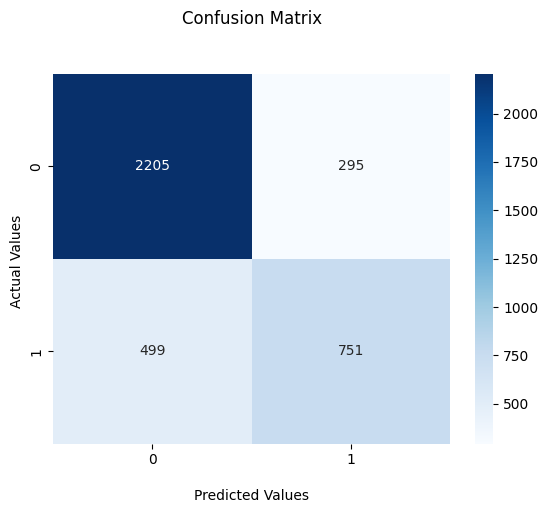

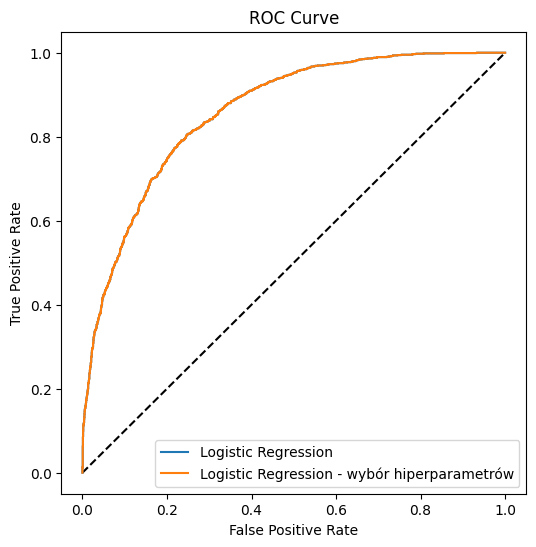

,Model,F1_score,AUC
0,Logistic Regression,0.654181,0.859499
1,Logistic Regression - wybór hiperparametrów,0.654181,0.859492


In [38]:
calculate_metrics(model_v2, 'Logistic Regression - wybór hiperparametrów', X_test, y_test)